# Processing and analyzing data from a roving detector

This tutorial demonstrates how to process and analyze data from a rover using the Cosmic Ray Neutron Python (CRNPy) library. The steps include loading the data, converting geographical coordinates to Cartesian coordinates, normalizing neutron counts, correcting for atmospheric effects, and visualizing the results.

First import the required packages.

In [1]:
# Import modules
import crnpy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


Load the data stored in the [.csv file](https://raw.githubusercontent.com/soilwater/crnpy/main/docs/examples/rover/gypsum_transect_01_may_2018.KSU).

In [2]:
# Load sample dataset
filepath = "https://raw.githubusercontent.com/soilwater/crnpy/main/docs/examples/rover/gypsum_transect_01_may_2018.KSU"
col_names = 'RecordNum,Date Time(UTC),barometric_pressure_Avg,P4_mb,P1_mb,T1_C,RH1,air_temperature_Avg,relative_humidity_Avg,Vbat,N1Cts,N2Cts,N3Cts,N4Cts,N5Cts,N6Cts,N7Cts,N8Cts,N1ETsec,N3ETsec,N5ETsec,N7ETsec,N1T(C),N1RH,N5T(C),N5RH,GpsUTC,LatDec,LongDec,Alt,Qual,NumSats,HDOP,Speed_kmh,COG,SpeedQuality,strDate'.split(',')

df = pd.read_csv(filepath, skiprows=20, names=col_names)
df['LongDec'] = df['LongDec'] * -1 # Raw data is in absolute values

# Parse timestamps and set as index
df['timestamp'] = pd.to_datetime(df['Date Time(UTC)'])

# Remove rows with missing coordinates
df['LatDec'].replace(0.0, np.nan, inplace=True)
df['LongDec'].replace(0.0, np.nan, inplace=True)
df.dropna(axis=0, subset=['LatDec','LongDec'], inplace=True)
df.reset_index(drop=True, inplace=True)

# Display a few rows to visualize dataset
df.head(3)


,RecordNum,Date Time(UTC),barometric_pressure_Avg,P4_mb,P1_mb,T1_C,RH1,air_temperature_Avg,relative_humidity_Avg,Vbat,...,LongDec,Alt,Qual,NumSats,HDOP,Speed_kmh,COG,SpeedQuality,strDate,timestamp
0,2,2018/05/01 14:15:00,962.95,962.8,961.4,23.2,35.4,20.9,72.7,13.574,...,-97.37195,393.2,2.0,10,0.8,0.00,270.7,A,10518.0,2018-05-01 14:15:00
1,3,2018/05/01 14:16:00,962.88,962.7,961.3,23.3,35.5,21.0,72.7,13.417,...,-97.37197,387.2,2.0,11,0.8,0.00,270.7,A,10518.0,2018-05-01 14:16:00
2,4,2018/05/01 14:17:00,962.64,962.5,961.1,23.4,35.4,21.2,72.2,13.282,...,-97.37199,388.2,1.0,11,0.8,3.89,356.3,A,10518.0,2018-05-01 14:17:00


Next, convert the latitude and longitude to UTM coordinates (x and y). A scatter plot is created to visualize the survey points.

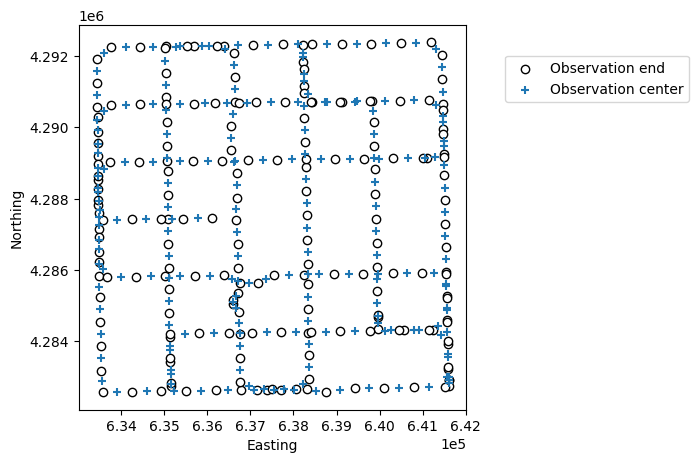

In [3]:
# Convert Lat and Lon to X and Y
df['x'],df['y'] = crnpy.latlon_to_utm(df['LatDec'], df['LongDec'], 14, missing_values=0.0)

# Create figure of survey points
plt.figure(figsize = (5,5))
plt.scatter(df['x'], df['y'], marker='o', edgecolor='k', facecolor='w', label = "Observation end")

# Estimate the center of the observation, assuming each timestamp is observation end time.
df['x'],df['y'] = crnpy.rover_centered_coordinates(df['x'], df['y']) 
plt.scatter(df['x'], df['y'], marker='+', label="Observation center")

plt.ticklabel_format(scilimits = (-5,5))
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.legend(loc=[1.1,.8])
plt.show()


The counts are normalized to counts per minute in case some observations covered a different timespan and total neutron counts are computed.

In [4]:
# Define columns names
counts_colums = ['N1Cts', 'N2Cts', 'N3Cts','N4Cts', 'N5Cts', 'N6Cts', 'N7Cts', 'N8Cts']
cont_times_col = ['N1ETsec', 'N1ETsec', 'N3ETsec','N3ETsec', 'N5ETsec', 'N5ETsec', 'N7ETsec', 'N7ETsec']

# Compute total neutron counts
df['total_raw_counts'] = crnpy.total_raw_counts(df[counts_colums])


### Neutron count correction 

#### Incommng neutron flux

Find stations with a cutoff rigidity similar to the estimated value based on the latitude and longitude, ensuring that the reference station is under a similar earth electromagnetic field. Note that the station is hardcoded in the second line as `station="NEWK"`. The user is required to manually define this after considering the potential options suggested. See [`get_incoming_neutron_flux()`](../../../reference/#crnpy.crnpy.get_incoming_neutron_flux), [`find_neutron_monitor()`](../../../reference/#crnpy.crnpy.find_neutron_monitor) and [`correction_incoming_flux()`](../../../reference/#crnpy.crnpy.correction_incoming_flux).

In [5]:
# Define transect start and end dates
start_date = df.iloc[0]['timestamp']
end_date = df.iloc[-1]['timestamp']

#Find stations with cutoff rigidity similar to estimated by lat,lon
crnpy.find_neutron_monitor(crnpy.cutoff_rigidity(df['LatDec'][0], df['LongDec'][0]), 
                             start_date=start_date, end_date=end_date)



Select a station with an altitude similar to that of your location. For more information go to: 'https://www.nmdb.eu/nest/help.php#helpstations

Your cutoff rigidity is 2.99 GV
    STID                          NAME     R  Altitude_m  Period available
13  DRBS                       Dourbes  3.18         225              True
31  MCRL  Mobile Cosmic Ray Laboratory  2.46         200              True
33  MOSC                        Moscow  2.43         200              True
40  NEWK                        Newark  2.40          50              True
20  IRK3                     Irkustk 3  3.64        3000              True
21  IRKT                       Irkustk  3.64         435              True


,STID,NAME,R,Altitude_m,Period available
13,DRBS,Dourbes,3.18,225,True
31,MCRL,Mobile Cosmic Ray Laboratory,2.46,200,True
33,MOSC,Moscow,2.43,200,True
40,NEWK,Newark,2.40,50,True
20,IRK3,Irkustk 3,3.64,3000,True
21,IRKT,Irkustk,3.64,435,True


In [6]:
# Download incoming neutron flux data from the Neutron Monitor Database (NMDB).
# Use utc_offset for Central Standard Time.
nmdb = crnpy.get_incoming_neutron_flux(start_date, end_date, station="NEWK", utc_offset=-6)


In [7]:
# Interpolate incoming neutron flux to match the timestamps in our rover data
df['incoming_flux'] = crnpy.interpolate_incoming_flux(nmdb['timestamp'], nmdb['counts'], df['timestamp'])


In [8]:
# Compute correction factor for incoming neutron flux
df['fi'] = crnpy.correction_incoming_flux(incoming_neutrons=df['incoming_flux'],
                                          incoming_Ref=df['incoming_flux'].iloc[0])


#### Atmospheric correction

NaN values in the atmospheric data are filled. The neutron counts are then corrected for atmospheric variables. See [`correction_humidity()`](../../../reference/#crnpy.crnpy.correction_humidity) and [`correction_pressure()`](../../../reference/#crnpy.crnpy.correction_pressure)

In [9]:
# Fill NaN values in atmospheric data
df[['barometric_pressure_Avg', 'relative_humidity_Avg', 'air_temperature_Avg']] = df[['barometric_pressure_Avg','relative_humidity_Avg', 'air_temperature_Avg']].interpolate(method='pchip', limit=24, limit_direction='both')

# Compute the pressure correction factor
df['fp'] = crnpy.correction_pressure(pressure=df['barometric_pressure_Avg'], Pref=df['barometric_pressure_Avg'].mean(), L=130)

# Estimate the absolute humidity and compute the vapor pressure correction factor
df['abs_humidity'] = crnpy.abs_humidity(df['relative_humidity_Avg'], df['air_temperature_Avg'])
df['fw'] = crnpy.correction_humidity(df['abs_humidity'], Aref=0)


In [10]:
# Apply correction factors
df['total_corrected_neutrons'] = df['total_raw_counts'] * df['fw'] / (df['fp'] * df['fi'])


The corrected counts are smoothed using a 2D smoothing function. The smoothed counts are then converted to volumetric water content (VWC) using the counts_to_vwc function.

In [11]:
# Smooth variable
df['corrected_neutrons_smoothed'] = crnpy.spatial_average(df['x'],
                                        df['y'],
                                        df['total_corrected_neutrons'],
                                        buffer= 800, method='median', rnd=True)

# Estimate lattice water based on texture
lattice_water = crnpy.lattice_water(clay_content=0.35)

# Estimate Soil Columetric Water Content
df['VWC'] = crnpy.counts_to_vwc(df['corrected_neutrons_smoothed'], N0=550, bulk_density=1.3, Wlat=lattice_water, Wsoc=0.01)

# Drop VWC NaN values before interpolating values
df = df.dropna(subset = ['VWC'])

# Interpolate variable using IDW (https://en.wikipedia.org/wiki/Inverse_distance_weighting)
X_pred, Y_pred, Z_pred = crnpy.interpolate_2d(df['x'],
                                        df['y'],
                                        df['VWC'],
                                        dx=250, dy=250, method='idw')


A gridded map of the Volumetric Water Content (VWC) is created using the interpolated x, y, and VWC values.

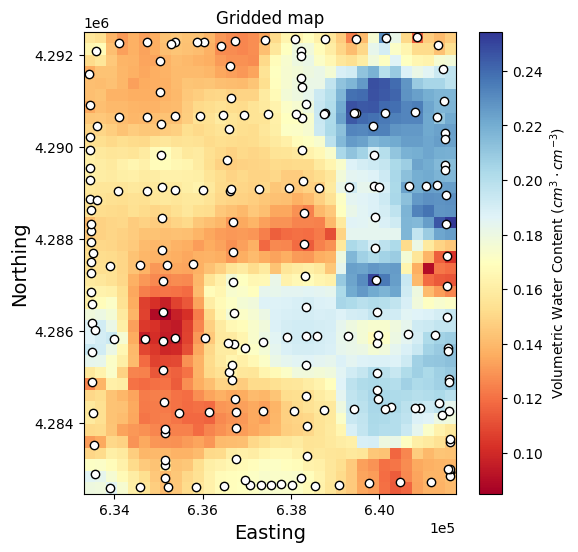

In [12]:
# Show interpolated grid
cmap = 'RdYlBu'

plt.figure(figsize=(6,6))
plt.title('Gridded map')
plt.pcolormesh(X_pred, Y_pred, Z_pred, cmap=cmap)
plt.colorbar(label=r"Volumetric Water Content $(cm^3 \cdot cm^{-3})$", location='right')
plt.scatter(df['x'], df['y'], marker='o', edgecolor='k', facecolor='w')
plt.ticklabel_format(scilimits=(-5,5))
plt.xlabel('Easting', size=14)
plt.ylabel('Northing', size=14)
plt.show()


Finally, a contour map of the VWC is created and displayed.

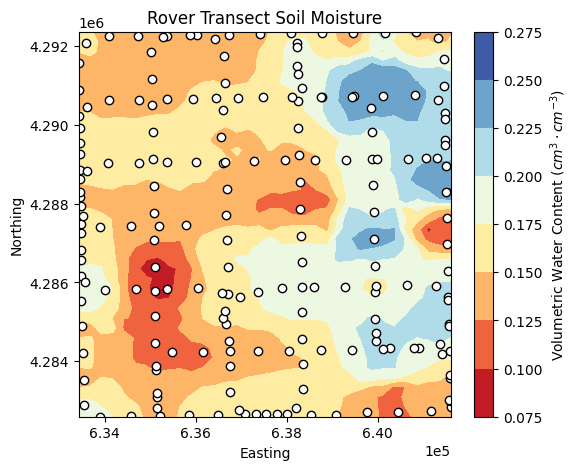

In [14]:
# Show contour map
cmap = 'RdYlBu'

fig = plt.figure(figsize=(6,5))
plt.title('Rover Transect Soil Moisture')
plt.contourf(X_pred, Y_pred, Z_pred, cmap=cmap)
plt.ticklabel_format(scilimits=(-5,5))
plt.colorbar(label=r"Volumetric Water Content $(cm^3 \cdot cm^{-3})$", location='right')
plt.scatter(df['x'], df['y'], marker='o', edgecolor='k', facecolor='w')
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.show()

fig.savefig("../rover.png", dpi=1000)

